In [0]:
! pip install comet-ml

In [0]:
! git clone https://github.com/dudeperf3ct/TextRecognizer.git

In [0]:
!pip install boltons

In [4]:
%cd TextRecognizer/Experiment-3/notebooks

/content/TextRecognizer/Experiment-3/notebooks


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
import absl.logging
logging.root.removeHandler(absl.logging._absl_handler)
absl.logging._warn_preinit_stderr = False
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


In [0]:
import sys
sys.path.append('..')

In [8]:
from src.data.iam_paragraphs import IAMPara
from src.models.line_detect_model import LineDetectModel
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from collections import defaultdict

Using TensorFlow backend.


In [9]:
dataset = IAMPara()
dataset.load_data()

0.00B [00:00, ?B/s]

[INFO] Downloading raw dataset...


586MB [00:29, 20.7MB/s]                           


[INFO] Download complete..
[INFO] Extracting IAM data...
[INFO] Extraction complete..
[INFO] Max crop width and height were found to be 1240x1156...
[INFO] Setting them to 1240x1240...
[INFO] Cropping paragraphs, generating ground truth, and saving debugging images to /content/TextRecognizer/Experiment-3/data/raw/iam_paragraphs/debug_crops...
[INFO] Rescued /content/TextRecognizer/Experiment-3/data/raw/iamdb/forms/e01-081.jpg: could not broadcast input array from shape (587,1236) into shape (587,1240)...
[INFO] Rescued /content/TextRecognizer/Experiment-3/data/raw/iamdb/forms/e01-086.jpg: could not broadcast input array from shape (687,1236) into shape (687,1240)...
[INFO] Loading IAM paragraph crops and ground truth from image files...


In [10]:
print(dataset)

IAM Paragraphs Dataset
Num classes: 3
Train: (1229, 256, 256) (1229, 256, 256, 3)
Test: (308, 256, 256) (308, 256, 256, 3)



## EDA

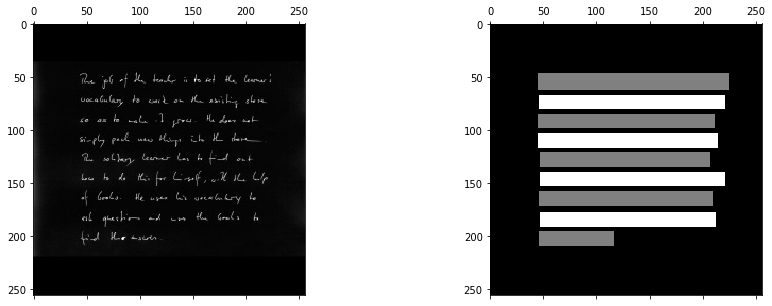

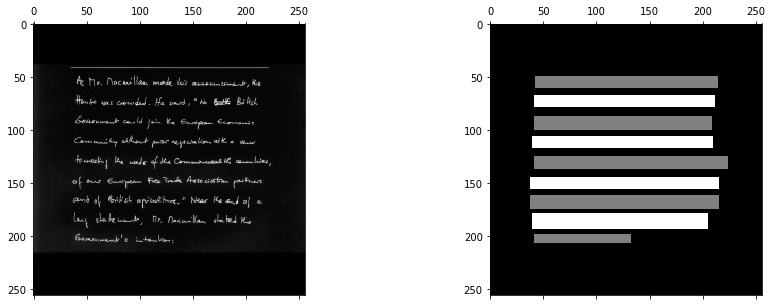

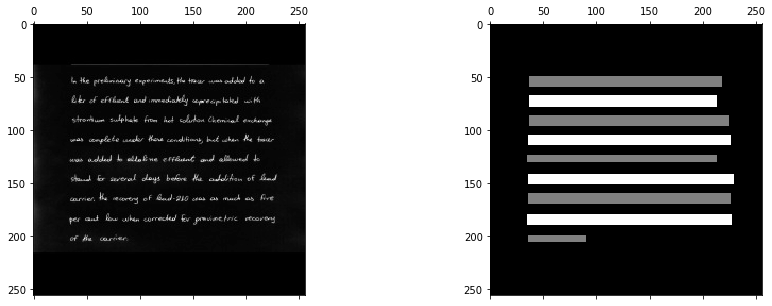

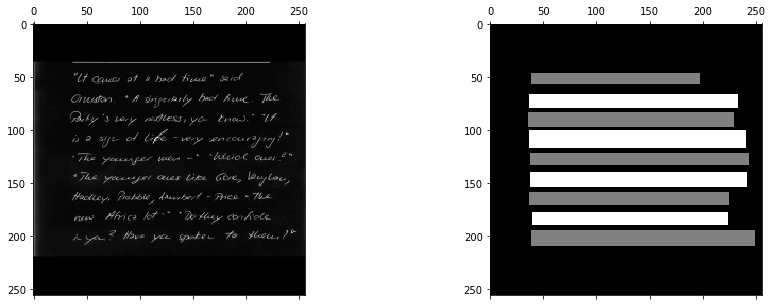

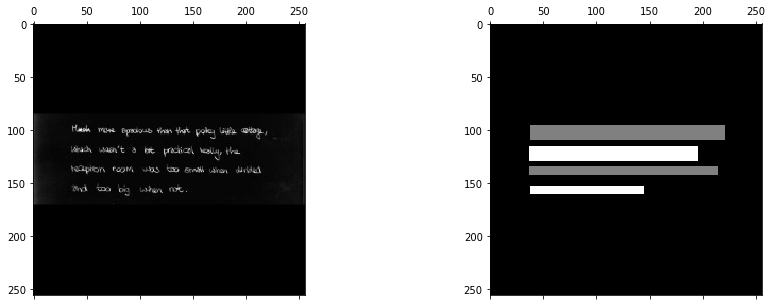

In [11]:
# Let's look at some train images and ground truth

for ind in range(5):
    image = dataset.x_train[ind]
    gt = dataset.y_train[ind].argmax(-1)

    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(121)
    ax1.matshow(image, cmap='gray')
    ax2 = fig.add_subplot(122)
    ax2.matshow(gt, cmap='gray')




[INFO] Arguments passed to data augmentation... {'width_shift_range': 0.06, 'height_shift_range': 0.1, 'horizontal_flip': True, 'zoom_range': 0.1, 'fill_mode': 'constant', 'cval': 0, 'shear_range': 3}


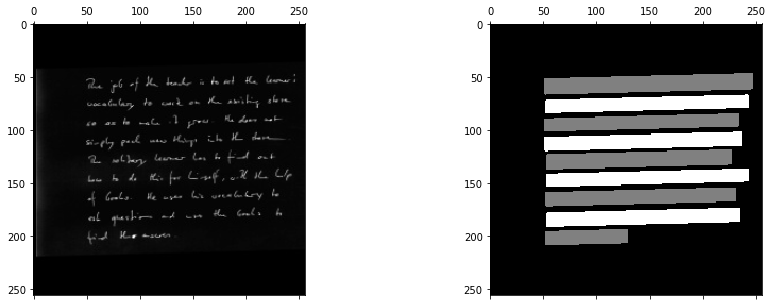

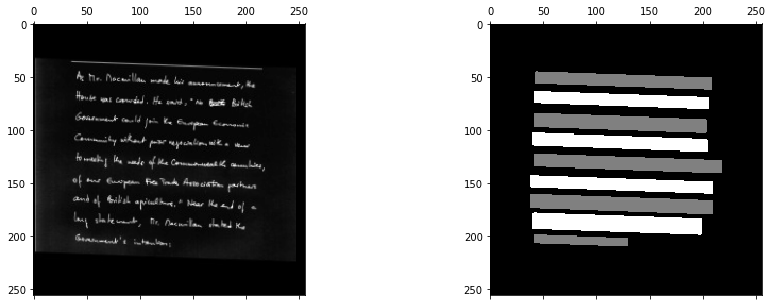

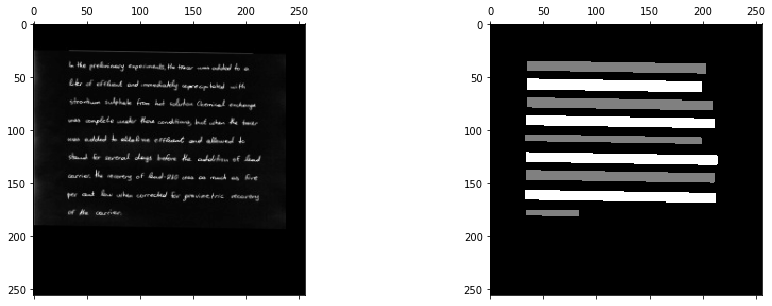

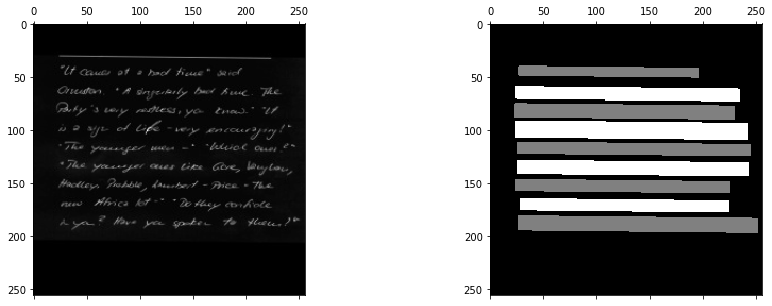

In [12]:
# Let's look at some train images and ground truth with data augmentation

line_detect_model = LineDetectModel()
x_batch, y_batch = dataset.x_train[:4], dataset.y_train[:4]
x_batch_aug, y_batch_aug = line_detect_model.augment_batch(x_batch, y_batch)

for ind in range(x_batch_aug.shape[0]):
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(121)
    ax1.matshow(x_batch_aug[ind], cmap='gray')
    ax2 = fig.add_subplot(122)
    ax2.matshow(y_batch_aug[ind].argmax(-1), cmap='gray')

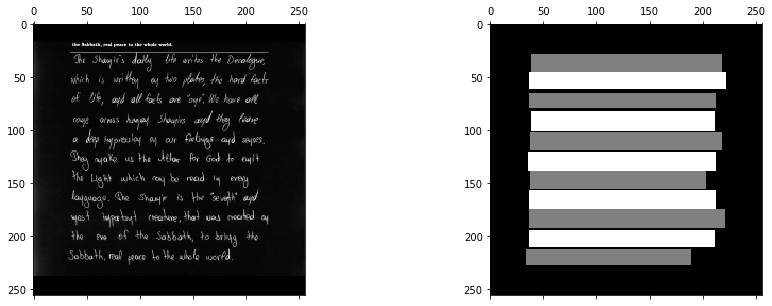

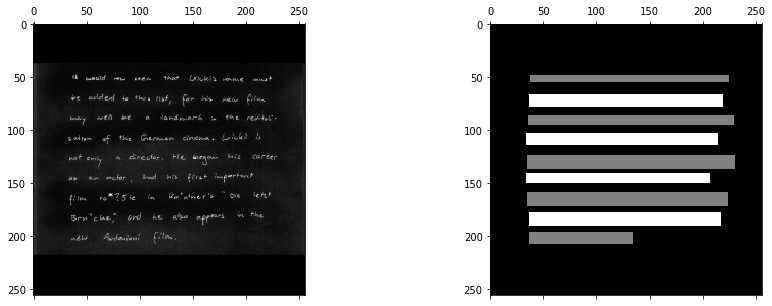

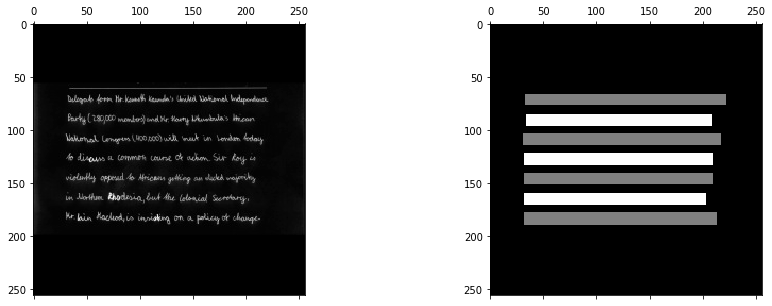

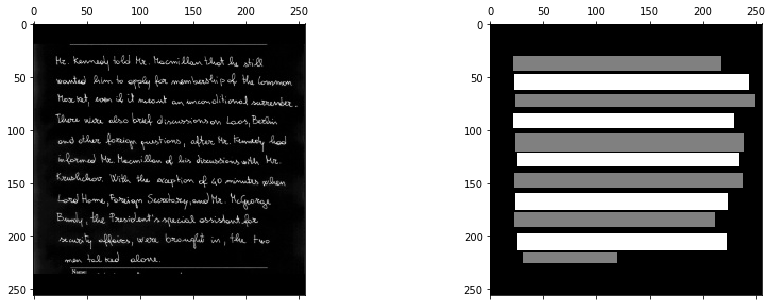

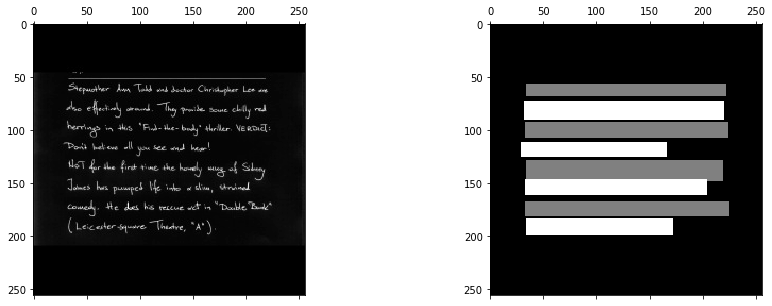

In [13]:
# Let's look at some test images and ground truth

for ind in range(5):
    image = dataset.x_test[ind]
    gt = dataset.y_test[ind].argmax(-1)

    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(121)
    ax1.matshow(image, cmap='gray')
    ax2 = fig.add_subplot(122)
    ax2.matshow(gt, cmap='gray')

In [42]:
%%writefile ../src/training/util.py

"""Function to train a model."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
#from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import EarlyStopping
from src.data.dataset import Dataset
from src.models.base_model import Model
from pathlib import Path
import numpy as np
import sys
sys.path.append(str(Path(__file__).resolve().parents[2]))
from src.visualization.visualize import plot_loss, plot_acc, save_model
from src.training.clr_callback import CyclicLR
from src.training.lr_find import LearningRateFinder
import matplotlib.pyplot as plt

EARLY_STOPPING = True
CYCLIC_LR = True
# adjust min_lr and max_lr after plotting lr_find
MIN_LR = 1e-4
MAX_LR = 1e-1
STEP_SIZE = 8
MODE = "triangular2"
SAVE_LR_PLOT = '../models/'

def train_model(
        model: Model,
        dataset: Dataset,
        epochs: int,
        batch_size: int,
        name : str,
        FIND_LR : bool = False) -> Model:
    """Train model."""
    callbacks = []

    if FIND_LR :
        # initialize the learning rate finder and then train with learning
        # rates ranging from 1e-10 to 1e+1
        print("[INFO] finding learning rate...")
        lrf = LearningRateFinder(model)
        lrf.find(
            dataset,
            1e-10, 
            1e+1,
            stepsPerEpoch=np.ceil((len(dataset['x_train']) / float(batch_size))),
            batchSize=batch_size)

        # plot the loss for the various learning rates and save the
        # resulting plot to disk
        lrf.plot_loss(name)
 
        # gracefully exit the script so we can adjust our learning rates
        # in the config and then train the network for our full set of
        # epochs
        print("[INFO] learning rate finder complete")
        print("[INFO] examine plot and adjust learning rates before training")

    else:
        if EARLY_STOPPING:
            early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, 
                            patience=5, verbose=1, restore_best_weights=True)
            callbacks.append(early_stopping)

        if CYCLIC_LR:
            cyclic_lr = CyclicLR(base_lr=MIN_LR, max_lr=MAX_LR,
                                step_size=STEP_SIZE * (dataset['x_train'].shape[0] // batch_size), 
                                mode=MODE)
            callbacks.append(cyclic_lr)

        model.network.summary()

        t = time.time()
        _history = model.fit(dataset=dataset, 
                            batch_size=batch_size, 
                            epochs=epochs, 
                            callbacks=callbacks,
                            lr=MIN_LR)
        print('[INFO] Training took {:2f} s'.format(time.time() - t))

        save_model(model.network, name)
        
        plot_loss(_history, name)
        #plot_acc(_history, name)

        return model

Overwriting ../src/training/util.py


## Training

In [0]:
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

In [16]:
! python ../src/training/train_model.py -b 16 -d IAMPara -m LineDetectModel -n lenet -find_lr True

Using TensorFlow backend.
[INFO] Getting dataset...
[INFO] Loading IAM paragraph crops and ground truth from image files...
tcmalloc: large alloc 1208745984 bytes == 0xb4846000 @  0x7f9589ebc001 0x7f9585a4fde5 0x7f9585ab46f1 0x7f9585ab67cf 0x7f9585b4f158 0x4f8925 0x4fa6c0 0x4f6128 0x4f7d60 0x4f876d 0x4f98c7 0x4f7a28 0x4f876d 0x4f98c7 0x4f7a28 0x4f876d 0x4f98c7 0x4f6128 0x4f7d60 0x4f876d 0x4f98c7 0x4f7a28 0x4f876d 0x4f98c7 0x4f6128 0x4f9023 0x6415b2 0x64166a 0x643730 0x62b26e 0x4b4cb0
[INFO] Training shape:  (1229, 256, 256) (1229, 256, 256, 3)
[INFO] Validation shape:  (62, 256, 256) (62, 256, 256, 3)
[INFO] Test shape:  (246, 256, 256) (246, 256, 256, 3)
[INFO] Setting up the model..
W0822 06:27:36.704890 140280245184384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 06:27:36.722934 140280245184384 deprecation_wrapper.p

In [39]:
#1e-4 1e-2 with cyclic lr
! python ../src/training/train_model.py -b 16 -d IAMPara -m LineDetectModel -n lenet -e 50

Using TensorFlow backend.
[INFO] Getting dataset...
[INFO] Loading IAM paragraph crops and ground truth from image files...
tcmalloc: large alloc 1208745984 bytes == 0xb40e2000 @  0x7f7f5b552001 0x7f7f570e5de5 0x7f7f5714a6f1 0x7f7f5714c7cf 0x7f7f571e5158 0x4f8925 0x4fa6c0 0x4f6128 0x4f7d60 0x4f876d 0x4f98c7 0x4f7a28 0x4f876d 0x4f98c7 0x4f7a28 0x4f876d 0x4f98c7 0x4f6128 0x4f7d60 0x4f876d 0x4f98c7 0x4f7a28 0x4f876d 0x4f98c7 0x4f6128 0x4f9023 0x6415b2 0x64166a 0x643730 0x62b26e 0x4b4cb0
[INFO] Training shape:  (1229, 256, 256) (1229, 256, 256, 3)
[INFO] Validation shape:  (62, 256, 256) (62, 256, 256, 3)
[INFO] Test shape:  (246, 256, 256) (246, 256, 256, 3)
[INFO] Setting up the model..
W0822 10:30:11.091832 140184974280576 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 10:30:11.108669 140184974280576 deprecation_wrapper.p

In [17]:
! python ../src/training/train_model.py -b 16 -d IAMPara -m LineDetectModel -n fcn -find_lr True

Using TensorFlow backend.
[INFO] Getting dataset...
[INFO] Loading IAM paragraph crops and ground truth from image files...
tcmalloc: large alloc 1208745984 bytes == 0xb5842000 @  0x7fa20d613001 0x7fa2091a6de5 0x7fa20920b6f1 0x7fa20920d7cf 0x7fa2092a6158 0x4f8925 0x4fa6c0 0x4f6128 0x4f7d60 0x4f876d 0x4f98c7 0x4f7a28 0x4f876d 0x4f98c7 0x4f7a28 0x4f876d 0x4f98c7 0x4f6128 0x4f7d60 0x4f876d 0x4f98c7 0x4f7a28 0x4f876d 0x4f98c7 0x4f6128 0x4f9023 0x6415b2 0x64166a 0x643730 0x62b26e 0x4b4cb0
[INFO] Training shape:  (1229, 256, 256) (1229, 256, 256, 3)
[INFO] Validation shape:  (62, 256, 256) (62, 256, 256, 3)
[INFO] Test shape:  (246, 256, 256) (246, 256, 256, 3)
[INFO] Setting up the model..
W0822 07:04:55.902122 140333990303616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 07:04:55.918824 140333990303616 deprecation_wrapper.p

In [41]:
# 1e-5 1e-3 with cyclic lr
! python ../src/training/train_model.py -b 16 -d IAMPara -m LineDetectModel -n fcn -e 50

Using TensorFlow backend.
[INFO] Getting dataset...
[INFO] Loading IAM paragraph crops and ground truth from image files...
tcmalloc: large alloc 1208745984 bytes == 0xb45be000 @  0x7fb844d47001 0x7fb8408dade5 0x7fb84093f6f1 0x7fb8409417cf 0x7fb8409da158 0x4f8925 0x4fa6c0 0x4f6128 0x4f7d60 0x4f876d 0x4f98c7 0x4f7a28 0x4f876d 0x4f98c7 0x4f7a28 0x4f876d 0x4f98c7 0x4f6128 0x4f7d60 0x4f876d 0x4f98c7 0x4f7a28 0x4f876d 0x4f98c7 0x4f6128 0x4f9023 0x6415b2 0x64166a 0x643730 0x62b26e 0x4b4cb0
[INFO] Training shape:  (1229, 256, 256) (1229, 256, 256, 3)
[INFO] Validation shape:  (62, 256, 256) (62, 256, 256, 3)
[INFO] Test shape:  (246, 256, 256) (246, 256, 256, 3)
[INFO] Setting up the model..
W0822 11:03:32.784916 140429409884032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 11:03:32.800299 140429409884032 deprecation_wrapper.p

In [18]:
! python ../src/training/train_model.py -b 16 -d IAMPara -m LineDetectModel -n custom -find_lr True

Using TensorFlow backend.
[INFO] Getting dataset...
[INFO] Loading IAM paragraph crops and ground truth from image files...
tcmalloc: large alloc 1208745984 bytes == 0xb3b52000 @  0x7fe541841001 0x7fe53d3d4de5 0x7fe53d4396f1 0x7fe53d43b7cf 0x7fe53d4d4158 0x4f8925 0x4fa6c0 0x4f6128 0x4f7d60 0x4f876d 0x4f98c7 0x4f7a28 0x4f876d 0x4f98c7 0x4f7a28 0x4f876d 0x4f98c7 0x4f6128 0x4f7d60 0x4f876d 0x4f98c7 0x4f7a28 0x4f876d 0x4f98c7 0x4f6128 0x4f9023 0x6415b2 0x64166a 0x643730 0x62b26e 0x4b4cb0
[INFO] Training shape:  (1229, 256, 256) (1229, 256, 256, 3)
[INFO] Validation shape:  (62, 256, 256) (62, 256, 256, 3)
[INFO] Test shape:  (246, 256, 256) (246, 256, 256, 3)
[INFO] Setting up the model..
W0822 07:45:36.500978 140622627813248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 07:45:36.515830 140622627813248 deprecation_wrapper.p

In [43]:
#1e-4 1e-1 with cyclic lr
! python ../src/training/train_model.py -b 16 -d IAMPara -m LineDetectModel -n custom -e 50

Using TensorFlow backend.
[INFO] Getting dataset...
[INFO] Loading IAM paragraph crops and ground truth from image files...
tcmalloc: large alloc 1208745984 bytes == 0xb4a38000 @  0x7f31f9365001 0x7f31f4ef8de5 0x7f31f4f5d6f1 0x7f31f4f5f7cf 0x7f31f4ff8158 0x4f8925 0x4fa6c0 0x4f6128 0x4f7d60 0x4f876d 0x4f98c7 0x4f7a28 0x4f876d 0x4f98c7 0x4f7a28 0x4f876d 0x4f98c7 0x4f6128 0x4f7d60 0x4f876d 0x4f98c7 0x4f7a28 0x4f876d 0x4f98c7 0x4f6128 0x4f9023 0x6415b2 0x64166a 0x643730 0x62b26e 0x4b4cb0
[INFO] Training shape:  (1229, 256, 256) (1229, 256, 256, 3)
[INFO] Validation shape:  (62, 256, 256) (62, 256, 256, 3)
[INFO] Test shape:  (246, 256, 256) (246, 256, 256, 3)
[INFO] Setting up the model..
W0822 11:32:32.440628 139852615612288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 11:32:32.456763 139852615612288 deprecation_wrapper.p

## Testing

In [0]:
from keras.models import load_model
from src.models.line_detect_model import LineDetectModel
from src.networks.lenet_fcn import lenetFCN
from src.networks.fcn import FCN
from src.networks.custom_fcn import customFCN
from keras.models import Model as KerasModel

In [0]:
ldm = LineDetectModel(network_fn=lenetFCN)
ldm.load_weights()

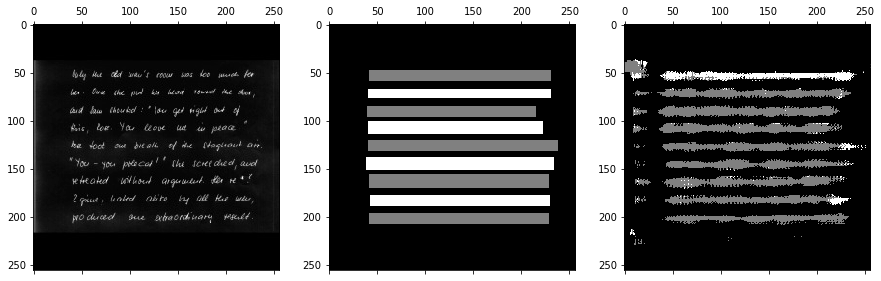

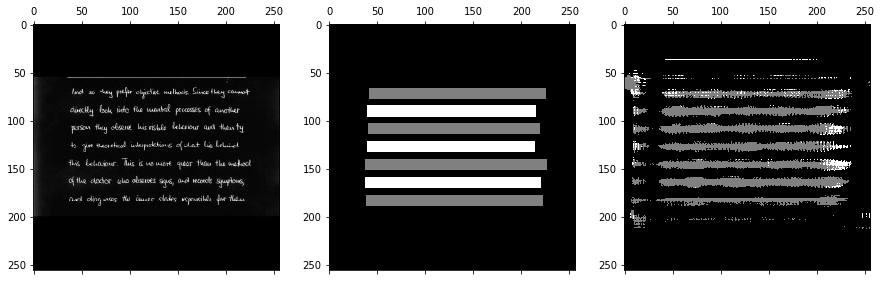

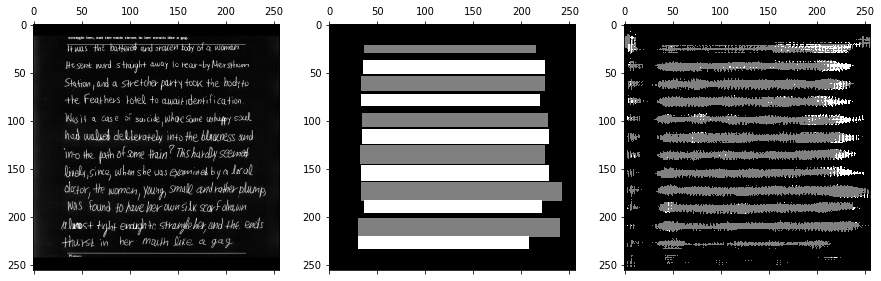

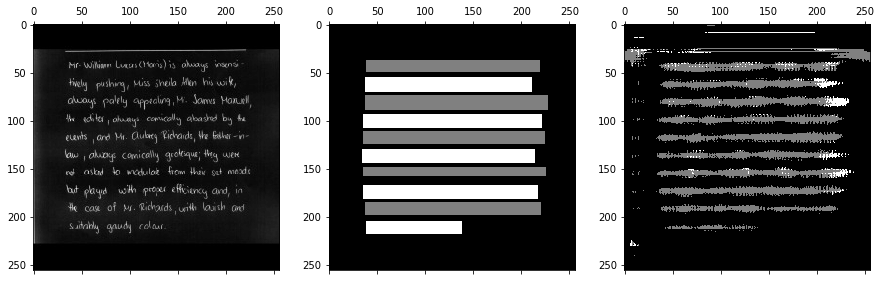

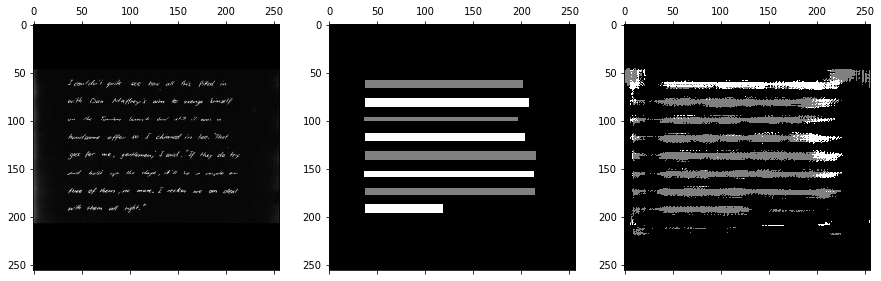

In [57]:
#lenet
# obtain one batch of test images
# get sample outputs
# plot the images in the batch, along with predicted and true labels

rnd_int = np.random.randint(low=0, high=len(dataset.x_test), size=5)
for ind in rnd_int:
    image = dataset.x_test[ind]
    gt = dataset.y_test[ind].argmax(-1)
    pred = ldm.predict_on_image(image).argmax(-1)

    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(131)
    ax1.matshow(image, cmap='gray')
    ax2 = fig.add_subplot(132)
    ax2.matshow(gt, cmap='gray')
    ax3 = fig.add_subplot(133)
    ax3.matshow(pred, cmap='gray')    

In [0]:
ldm = LineDetectModel(network_fn=FCN)
ldm.load_weights()

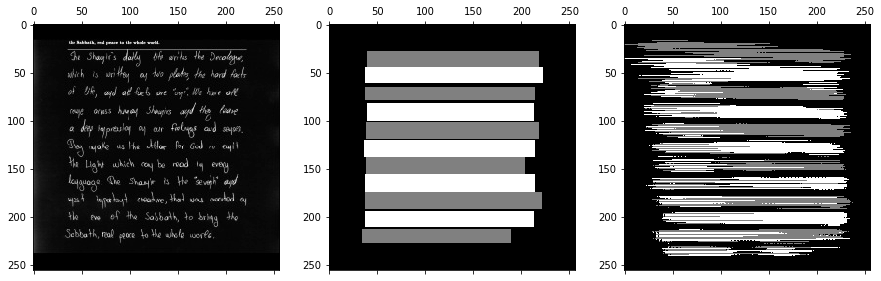

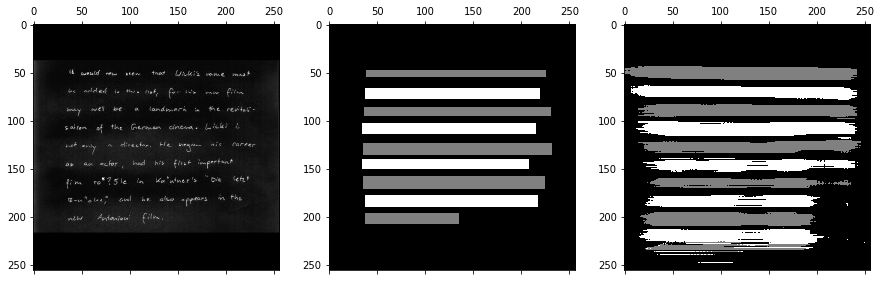

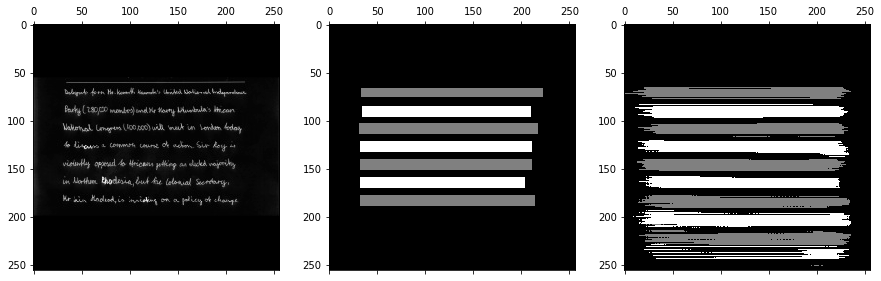

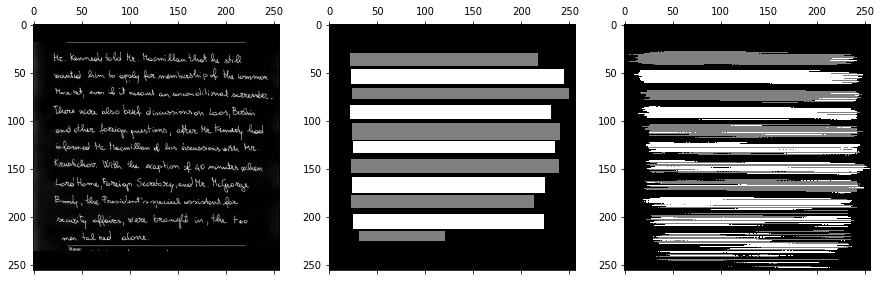

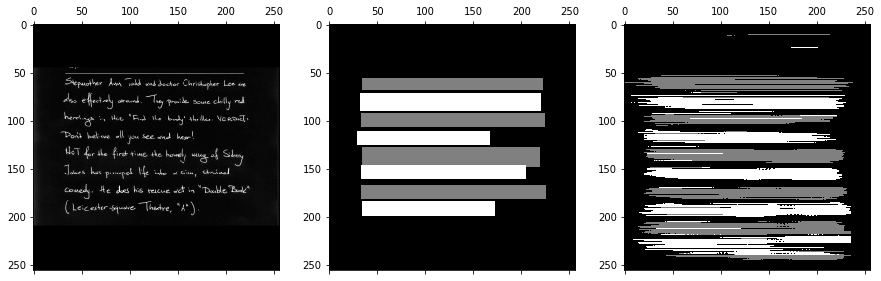

In [53]:
#lenet
# obtain one batch of test images
# get sample outputs
# plot the images in the batch, along with predicted and true labels

rnd_int = np.random.randint(low=0, high=len(dataset.x_test), size=5)
for ind in rnd_int:
    image = dataset.x_test[ind]
    gt = dataset.y_test[ind].argmax(-1)
    pred = ldm.predict_on_image(image).argmax(-1)

    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(131)
    ax1.matshow(image, cmap='gray')
    ax2 = fig.add_subplot(132)
    ax2.matshow(gt, cmap='gray')
    ax3 = fig.add_subplot(133)
    ax3.matshow(pred, cmap='gray')    

In [0]:
ldm = LineDetectModel(network_fn=customFCN)
ldm.load_weights()

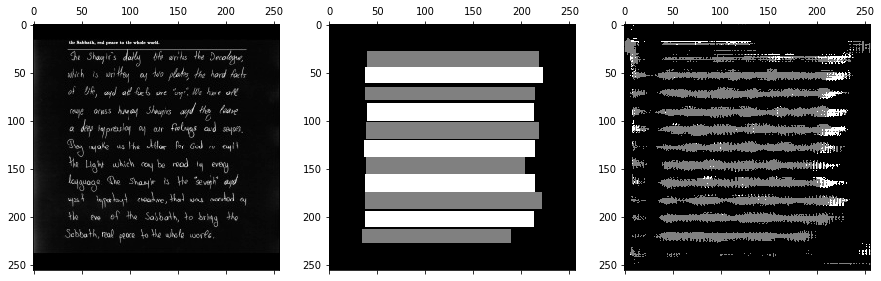

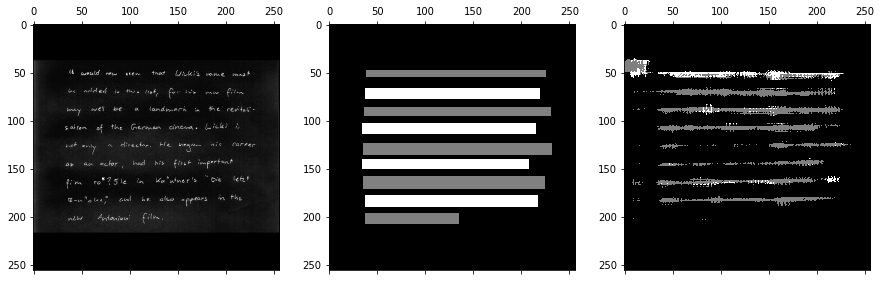

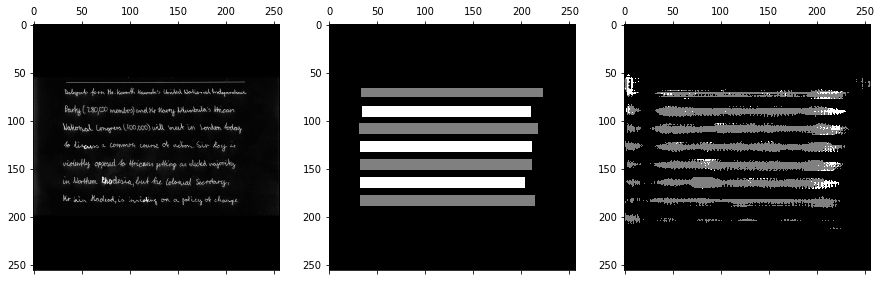

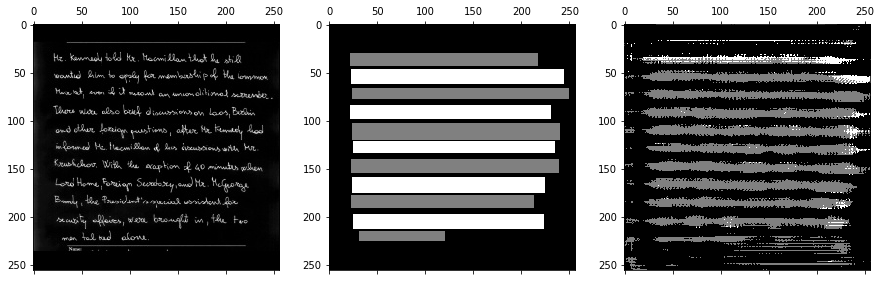

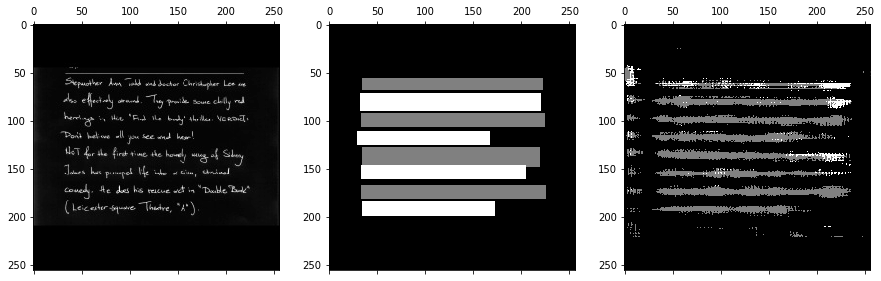

In [55]:
#lenet
# obtain one batch of test images
# get sample outputs
# plot the images in the batch, along with predicted and true labels

rnd_int = np.random.randint(low=0, high=len(dataset.x_test), size=5)
for ind in rnd_int:
    image = dataset.x_test[ind]
    gt = dataset.y_test[ind].argmax(-1)
    pred = ldm.predict_on_image(image).argmax(-1)

    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(131)
    ax1.matshow(image, cmap='gray')
    ax2 = fig.add_subplot(132)
    ax2.matshow(gt, cmap='gray')
    ax3 = fig.add_subplot(133)
    ax3.matshow(pred, cmap='gray')    